# 🔍 Inference with Saved State-LSTM + Random Forest Classification

This notebook loads previously saved state-based LSTM models, detects anomalies, and classifies the detected anomalies using a pre-trained Random Forest model.

## 📦 Step 1: Import Libraries

In [64]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
import joblib
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt


## 📥 Step 2: Load and Prepare Reshaped Data

In [65]:

df = pd.read_csv("../test_csv/motor_monitor_0_reshaped.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()


,timestamp,power,rpm,temperature,vibration,is_anomaly,state,label
0,2025-04-07 00:00:00,4.761313,2.709206,22.0,7.625940,False,off,Normal
1,2025-04-07 00:01:00,4.411987,2.795459,22.0,7.408486,False,off,Normal
2,2025-04-07 00:02:00,4.107287,2.704222,22.0,7.501584,False,off,Normal
3,2025-04-07 00:03:00,5.405146,2.605857,22.0,7.220880,False,off,Normal
4,2025-04-07 00:04:00,4.166757,2.750449,22.0,7.605353,False,off,Normal


## ⚙️ Step 3: Define Sliding Window Anomaly Detector

In [66]:

def create_sequences(data, seq_length=30):
    return np.array([data.iloc[i:i+seq_length].values for i in range(len(data)-seq_length)])

def detect_state_anomalies(df_state, model_path, feature_cols):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_state[feature_cols])
    sequences = create_sequences(pd.DataFrame(scaled))
    
    model = load_model(model_path, compile=False)
    reconstructions = model.predict(sequences)
    errors = np.mean((reconstructions - sequences[:, -reconstructions.shape[1]:, :]) ** 2, axis=(1, 2))
    
    hist, bins = np.histogram(errors, bins=10000)
    mode_index = np.argmax(hist)
    mode = (bins[mode_index] + bins[mode_index + 1]) / 2
    threshold = mode
    #threshold = np.percentile(errors, 95)
    print(f"Threshold for {model_path}: {threshold:.6f}")
    
    flags = np.array([False] * len(df_state))
    flags[30:len(errors)+30] = errors > threshold
    df_state['reconstruction_error'] = [0.0]*30 + errors.tolist()
    df_state['is_anomaly'] = flags
    return df_state


## 🧠 Step 4: Apply Detection by State

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Threshold for ../test_cases/saved_models/lstm_off.h5: 0.056014


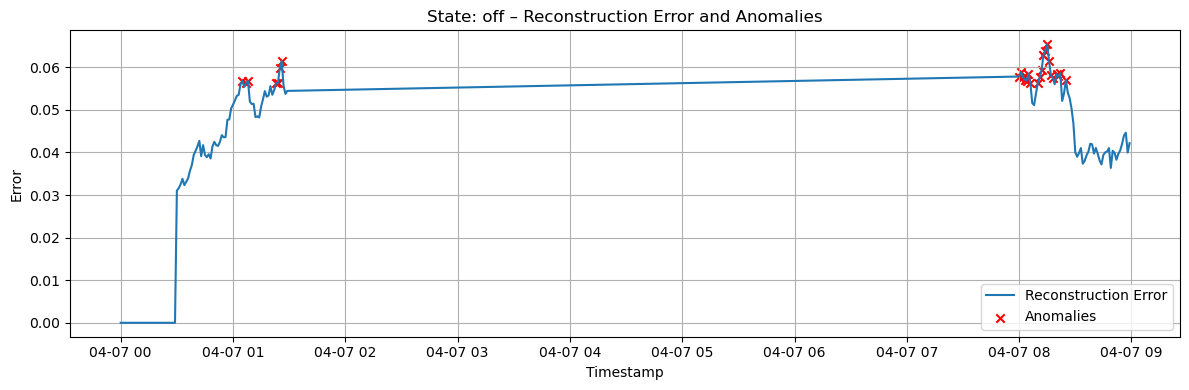

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
Threshold for ../test_cases/saved_models/lstm_idle.h5: 0.038052


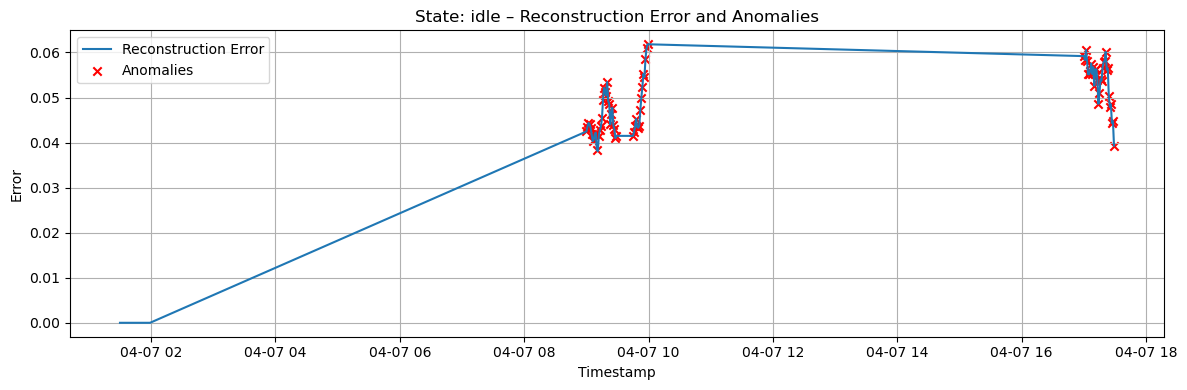

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Threshold for ../test_cases/saved_models/lstm_run.h5: 29962.327567


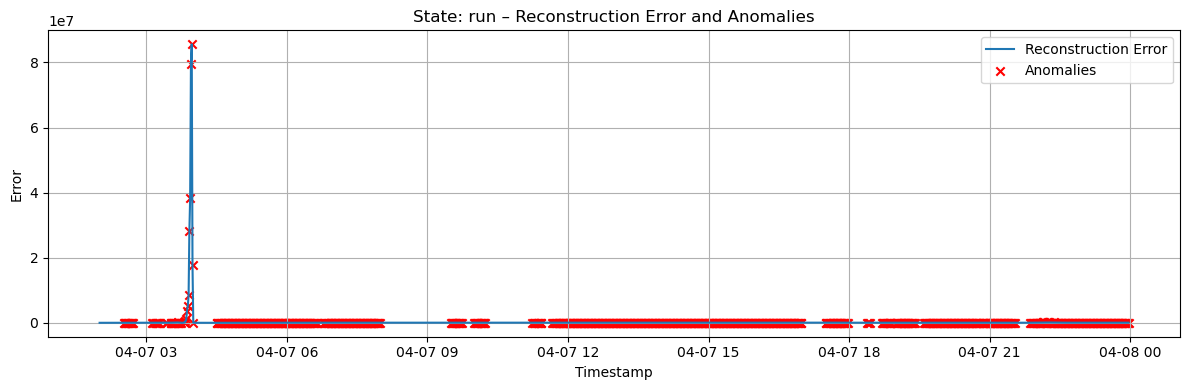

In [67]:

df_all = pd.DataFrame()
feature_cols = ['power', 'rpm', 'temperature', 'vibration']
model_paths = {
    'run': "../test_cases/saved_models/lstm_run.h5",
    'idle': "../test_cases/saved_models/lstm_idle.h5",
    'off': "../test_cases/saved_models/lstm_off.h5"
}

for state in df['state'].unique():
    df_state = df[df['state'] == state].copy()
    model_path = model_paths.get(state)
    if model_path:
        df_state = detect_state_anomalies(df_state, model_path, feature_cols)
        df_all = pd.concat([df_all, df_state])

    # 📊 Plotting section
    plt.figure(figsize=(12, 4))
    plt.plot(df_state['timestamp'], df_state['reconstruction_error'], label='Reconstruction Error')
    plt.scatter(
        df_state[df_state['is_anomaly']]['timestamp'],
        df_state[df_state['is_anomaly']]['reconstruction_error'],
        color='red', label='Anomalies', marker='x'
    )
    plt.title(f"State: {state} – Reconstruction Error and Anomalies")
    plt.xlabel("Timestamp")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
df = df_all.sort_values('timestamp').reset_index(drop=True)




## 🤖 Step 5: Classify Detected Anomalies with Random Forest

In [68]:

# One-hot encode state to match training
df_encoded = pd.get_dummies(df, columns=["state"])
for col in ["state_off", "state_run", "state_idle"]:
    if col not in df_encoded.columns:
        df_encoded[col] = 0

# Load RF model
rf_model = joblib.load("../test_cases/saved_models/random_forest.pkl")

# Filter anomaly rows
anomaly_df = df_encoded[df_encoded["is_anomaly"] == True].copy()
features = ['power', 'rpm', 'temperature', 'vibration', 'state_idle', 'state_off', 'state_run']

# Evaluate
if 'label' in anomaly_df.columns:
    X_anomaly = anomaly_df[features]
    y_true = anomaly_df['label']
    y_pred = rf_model.predict(X_anomaly)
    
    print("🔍 Classification Report (for detected anomalies):")
    print(classification_report(y_true, y_pred))
else:
    print("⚠️ 'label' column not found. Cannot compute classification report.")


🔍 Classification Report (for detected anomalies):
                    precision    recall  f1-score   support

            Normal       1.00      1.00      1.00       970
       Overheating       1.00      1.00      1.00        11
      Power_outage       1.00      1.00      1.00        26
Vibration_increase       1.00      1.00      1.00        19

          accuracy                           1.00      1026
         macro avg       1.00      1.00      1.00      1026
      weighted avg       1.00      1.00      1.00      1026



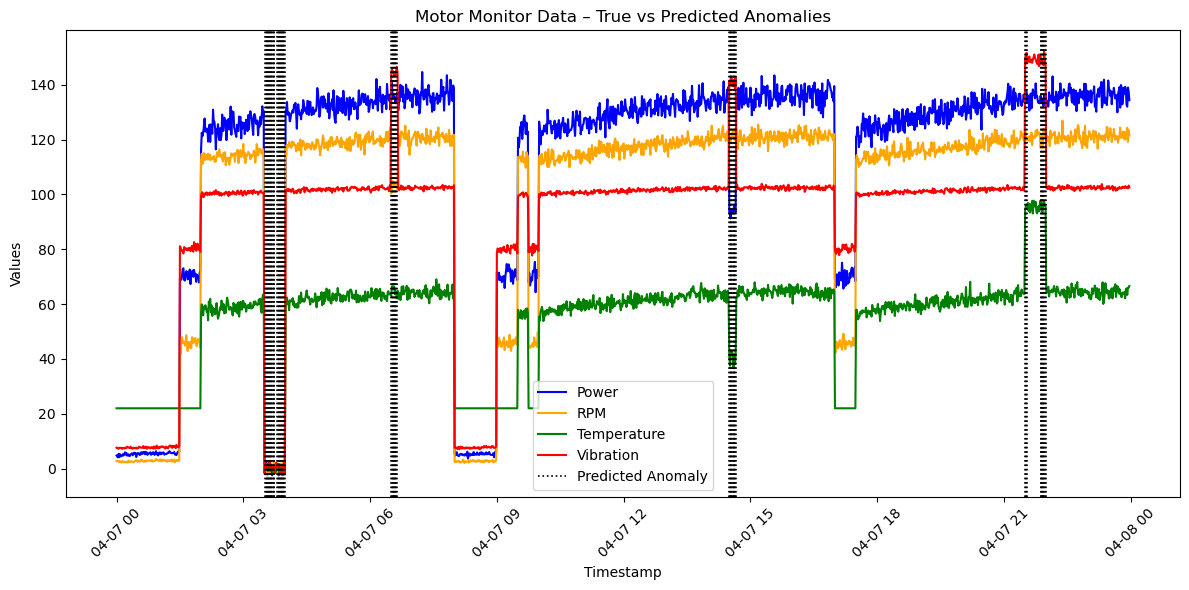

In [70]:
# Get indices of true and predicted anomalies
true_anomaly_idx = X_anomaly.index[y_true != "Normal"]
pred_anomaly_idx = X_anomaly.index[y_pred != "Normal"]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['power'], label='Power', color='blue')
plt.plot(df['timestamp'], df['rpm'], label='RPM', color='orange')
plt.plot(df['timestamp'], df['temperature'], label='Temperature', color='green')
plt.plot(df['timestamp'], df['vibration'], label='Vibration', color='red')

# # Plot true anomaly lines (dotted)
# for ts in anomaly_df.loc[true_anomaly_idx, 'timestamp']:
#     plt.axvline(x=ts, color='red', linestyle=':', linewidth=1.2, label='True Anomaly' if 'True Anomaly' not in plt.gca().get_legend_handles_labels()[1] else "")

# Plot predicted anomaly lines (solid)
for ts in anomaly_df.loc[pred_anomaly_idx, 'timestamp']:
    plt.axvline(x=ts, color='black', linestyle=':', linewidth=1.2, label='Predicted Anomaly' if 'Predicted Anomaly' not in plt.gca().get_legend_handles_labels()[1] else "")


plt.title('Motor Monitor Data – True vs Predicted Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()